In [51]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import colorsys
from matplotlib.patches import Rectangle
import matplotlib.transforms
from PIL import Image
from scipy.optimize import curve_fit
from scipy.integrate import simpson

import csv
from csv import writer

import os
import statistics



Ну короче эта типа возникновение рамановского излучения в волокне

Гипотеза 1: чем больше мощность тем больше раман (посмотреть зависимость)

Гипотеза 2: температура высвета коррелирует с шириной спектра??? афигеть просто

Имеется файл с данными о зависимости выходной мощности и температуры высвета (фрагмента волокна, покрытого высвечивающим полимером) от процента тока накачки относительно максимального. Давайте считаем эти данные и построим эти зависимости.

Из графика видно, что зависимость выходной мощности не совесм линейная при маленбких значениях тока, поэтому воспользуемся функцией линейной интерполяции.

power 30
y [30.0, 30.0, 55.8, 121.9, 190.0, 255.0, 312.0, 390.0, 450.0, 504.0, 560.0]
power 42
y [40.0, 40.0, 65.0, 133.1, 195.0, 263.0, 327.0, 396.0, 452.0, 520.0, 584.0]
power 56
y [50.0, 52.1, 78.0, 143.0, 210.0, 276.0, 340.0, 405.0, 468.0, 532.0, 592.0]
[50.0, 54.69, 91.0, 163.1, 236.4, 308.0, 379.0, 449.1, 519.2, 586.0]
[40.0, 42.5, 78.62, 151.67, 222.2, 295.0, 368.4, 435.2, 506.4, 577.6]
[30.0, 32.58, 69.02, 142.33, 216.0, 283.5, 358.8, 432.0, 493.2, 554.4]


C:\Users\vika\AppData\Local\Temp\ipykernel_3732\2795865922.py:21: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(I, y, 'ro', marker = 'o', markersize = 2)


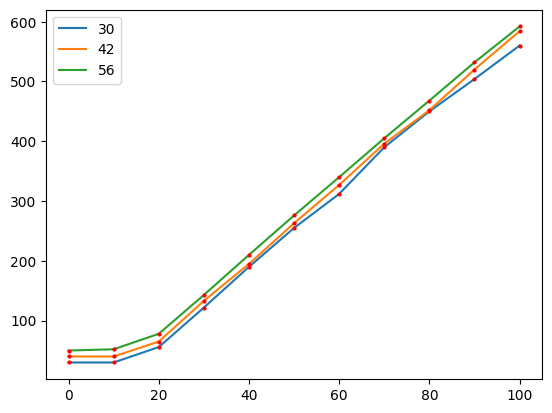

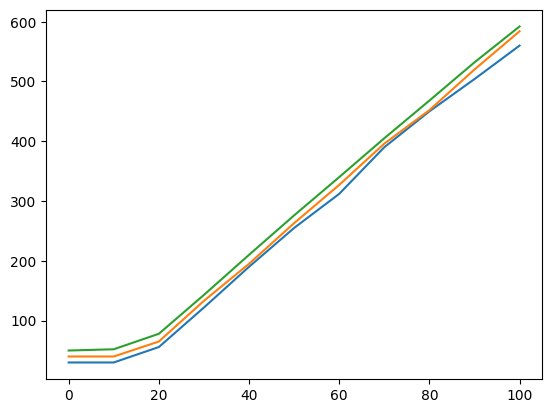

In [52]:

# Считываем файл
Pout_data = pd.read_csv('Pout_data.dat', sep = '\t')
I = Pout_data.iloc[:, 0]

Powers =['30', '42', '56']
Power_lambdas= dict.fromkeys(Powers) 

def get_power(P_nom, Iproc ):
    return Power_lambdas[P_nom](Iproc)
 
fig, ax = plt.subplots()
x = np.linspace(0, 100, 101)
for power in Powers:
    print('power', power)
    y = [float(a.replace(',', '.')) for a in Pout_data['Pout' + power]]
    print('y', y)
    p = lambda i, I = I, y = y: np.interp(i, I, y) 
    Power_lambdas[power] = p

    plt.plot(x, get_power(power, x),  label = power)
    plt.plot(I, y, 'ro', marker = 'o', markersize = 2)
       
plt.legend()
    
fig, ax = plt.subplots()
for power in Powers:
    plt.plot(x, get_power(power, x),  label = power)
   
    
print([get_power('56', i) for i in range(0, 100, 11)])
print([get_power('42', i) for i in range(0, 100, 11)])
print([get_power('30', i) for i in range(0, 100, 11)])


In [53]:

def read_spectrum(f:str):
    Pnom = f.split('//')[-1].split('.')[0].split('-')[0]
    Iproc = f.split('//')[-1].split('.')[0].split('-')[1]
    Pout = get_power(Pnom, float(Iproc))

    colnames = ['nm', 'dBm']
    scan = pd.read_csv(f, skiprows = 29, names=colnames)

    lmbdas = scan['nm']
    # value = 10**(scan['dBm']/10)
    value = scan['dBm']
    return {'Pout': Pout, 
            'lmbdas' :lmbdas,
            'value': value}

path = '600//'

dict_template = {'data':[] }

non_raman = {'30': {'data':[] }, 
             '42': {'data':[] }, 
             '56': {'data':[] }}

raman = {'56': {'data':[] }}


for name in os.listdir(path):
    f = os.path.join(path, name)
    # print(f, os.path.isfile(f), name[-4:])
    if os.path.isfile(f) and name[-4:] == '.CSV':

        spectrum = read_spectrum(f)
        split = name.split('.')[0].split('-')

        if len(split) == 2:
            non_raman[split[0]]['data'].append(spectrum)
            # print(len(non_raman[split[0]]['data']))

        elif len(split) == 3:
            raman[split[0]]['data'].append(spectrum)
            # print(len(raman[split[0]]['data']))


(1072.2967, 1.0566999999998643, -27.021, 0.8441467987333563)

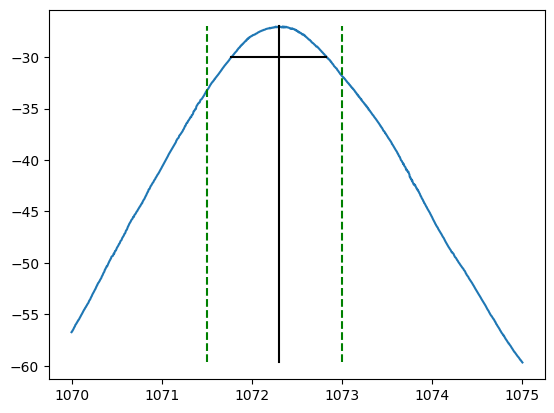

In [54]:
# Функция, извлекающая информацию о пике излучения на спектре в заданном диапазоне длин волн. 
# При сообщении дополнительного параметра out = 1 выводит график. 

def analyze_spectrum(spectrum, lmbda_1, lmbda_2, out = 0):
    
    lmbdas = spectrum['lmbdas']
    value = spectrum['value']
    i_value = 10**(spectrum['value']/10)
    idx1 = np.where(lmbdas == lmbda_1)[0][0]
    idx2 = np.where(lmbdas == lmbda_2)[0][0]

    all_power = simpson(i_value, x = lmbdas)
    peak_power = simpson(i_value[idx1:idx2], x = lmbdas[idx1:idx2])
    power_share = peak_power/all_power
    
    power_peak = max(value[idx1:idx2])
    central_lmbda = lmbdas[np.where(value == power_peak)[0][0]]

    left = lmbdas[np.where(value[idx1:idx2] >= power_peak-3)[0][0]]
    right = lmbdas[np.where(value[idx1:idx2] >= power_peak-3)[0][-1]]
    width = right - left

    if out == 1:
        plt.plot(lmbdas, value, label = spectrum['Pout'])
        plt.plot([lmbda_1, lmbda_1], [min(value), power_peak], 'g--')
        plt.plot([lmbda_2, lmbda_2], [min(value), power_peak], 'g--')

        plt.plot([central_lmbda, central_lmbda], [min(value), power_peak], color = 'black')
        plt.plot([central_lmbda - width/2, central_lmbda + width/2], [power_peak-3, power_peak-3], color = 'black')  

    return central_lmbda, width, power_peak, power_share


analyze_spectrum(non_raman['56']['data'][-1], 1071.5, 1073, 1)

Исследуем спектры для номинальной мощности задающего 30Вт:

In [55]:
colnames = ['Power', 'central_lmbda', 'width', 'power_peak', 'power_share']

result_30 = [(item['Pout'], *analyze_spectrum(item, 1070, 1075)) for item in non_raman['30']['data']]
df_30 = pd.DataFrame(result_30, columns = colnames)

result_42 = [(item['Pout'], *analyze_spectrum(item, 1070, 1075)) for item in non_raman['42']['data']]
df_42 = pd.DataFrame(result_42, columns = colnames)

result_56 = [(item['Pout'], *analyze_spectrum(item, 1070, 1075)) for item in non_raman['56']['data']]
df_56 = pd.DataFrame(result_56, columns = colnames)



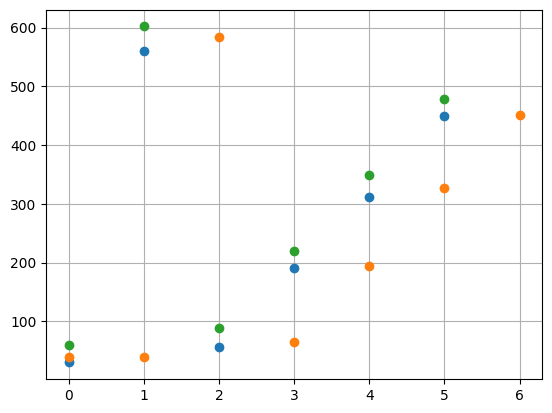

In [56]:
# Зависимость ширины спектра от мощности излучения
fig, ax = plt.subplots()
plt.plot(df_30['Power'],  'o')
plt.plot(df_42['Power'],  'o')
plt.plot(df_56['Power'] + 10,  'o')
plt.grid()

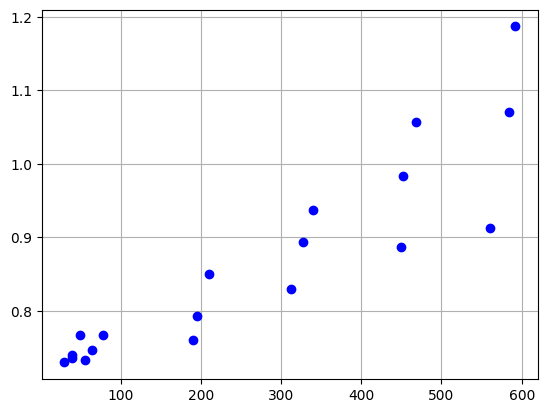

In [57]:
# Зависимость ширины спектра от мощности излучения
fig, ax = plt.subplots()
plt.plot(df_30['Power'], df_30['width'], 'bo')
plt.plot(df_42['Power'], df_42['width'], 'bo')
plt.plot(df_56['Power'], df_56['width'], 'bo')
plt.grid()

Перейдем к исследованию рамановского излучения. Данные были получены измерением спектров на большем диапазоне длин волн.

(-90.0, -17.502450000000003)

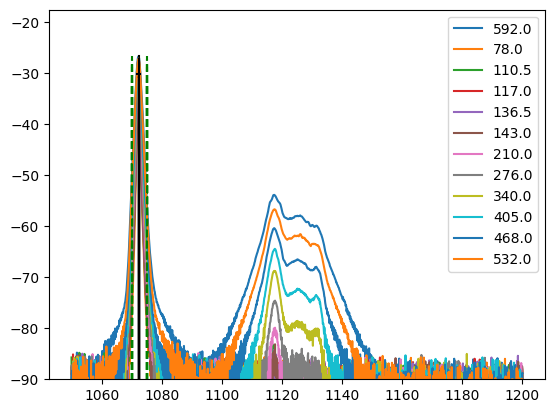

In [58]:
result_raman_1072 = [(item['Pout'], *analyze_spectrum(item, 1070, 1075, 1)) for item in raman['56']['data']]
result_raman_1120 = [(item['Pout'], *analyze_spectrum(item, 1100, 1150)) for item in raman['56']['data']]
df_raman_1072 = pd.DataFrame(result_raman_1072, columns = colnames)
df_raman_1120 = pd.DataFrame(result_raman_1120, columns = colnames)
plt.legend()
plt.ylim(-90, )

Известно, что стоксова волна 
$
{\displaystyle \omega _{c}=\omega _{0}-\Omega } 
$
экспоненциально усиливается по мере распространения в среде:
$${\displaystyle I_{c}=I_{c0}e^{gI_{0}z}}$$
При этом интенсивность связана с мощностью как $P = I \cdot S_eff$, где $S_eff = \pi * r^2$. Соответсвенно уравнение принимает вид :
$${\displaystyle P_{c}=P_{c0}e^{{g  P_{0}z}/S_eff}}$$
При фиксированном значении $z$  зависимость от мощности в волокне позволяет определить коэффициент усиления $g$.

Коэффициент усиления g = 9.30E-05 м/Вт


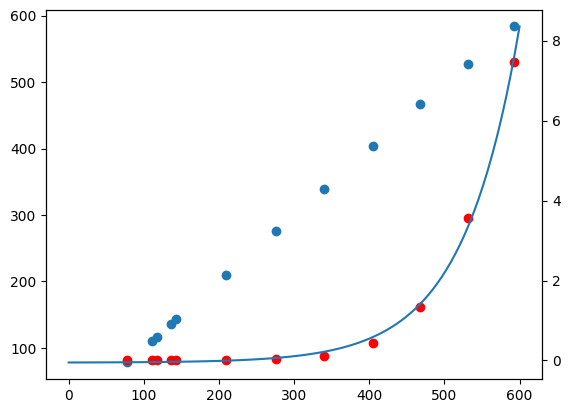

In [90]:
def f_exp(x, a, b, c):
    return a * np.exp(b* x) + c

fig, ax = plt.subplots()
ax.plot(df_raman_1072['Power'], df_raman_1072['power_share'] * df_raman_1072['Power'] , 'o')

ax1 = ax.twinx()
ax1.plot(df_raman_1120['Power'], df_raman_1120['power_share'] * df_raman_1120['Power'] , 'ro')


xx = np.linspace(0, 600, 100)
p0 = (0.01, 0.011, 0)
s_popt, s_pcov = curve_fit(f_exp, df_raman_1120['Power'], df_raman_1120['power_share'] * df_raman_1120['Power'], p0 = p0)
ax1.plot(xx, f_exp(xx, *s_popt))


r = 164e-3
S_eff = np.pi* r**2
z = 12
b = s_popt[1] #показатель экспоненты
g = b * S_eff /z


s_format = "{:.2E}"
print(f'Коэффициент усиления g = {s_format.format(g)} м/Вт')


# print(f'Относительные погрешности: {item for item in np.diag(s_pcov)/s_popt} ')


Вывод:
1. Установлено наличие корреляции между шириной спектра излучения и температурой высвета.
2. Регрессионным методом была проверена теоретическая зависимости мощности рамановского излучения. Из коэффициента апрксимации определен коээффицент усиления в волокне.